This notebook reviews some basic notation and concepts related to neural networks. It will skip many details that would have been covered in your earlier Stochastics and Machine Learning course, but will set a basis for us jumping into more advanced topics in a few chapters.

Before we get started with PyTorch code, I encourage you first to interactive with the ConvNetJS demo, specifically the [interactive 1D Regression](https://cs.stanford.edu/people/karpathy/convnetjs/demo/regression.html) where you can toogle on and off the different layers and plotting functions, as well as the [2D Classification demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html) to see how a neural network is just performing a series of feature transformations that ultimately lead to a linear classification boundary. These demos help build a good intuition for what is going on before we move onto more obtuse PyTorch code.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

## Example of PyTorch SGD for Linear Regression and a Simple Feed-Forward Network

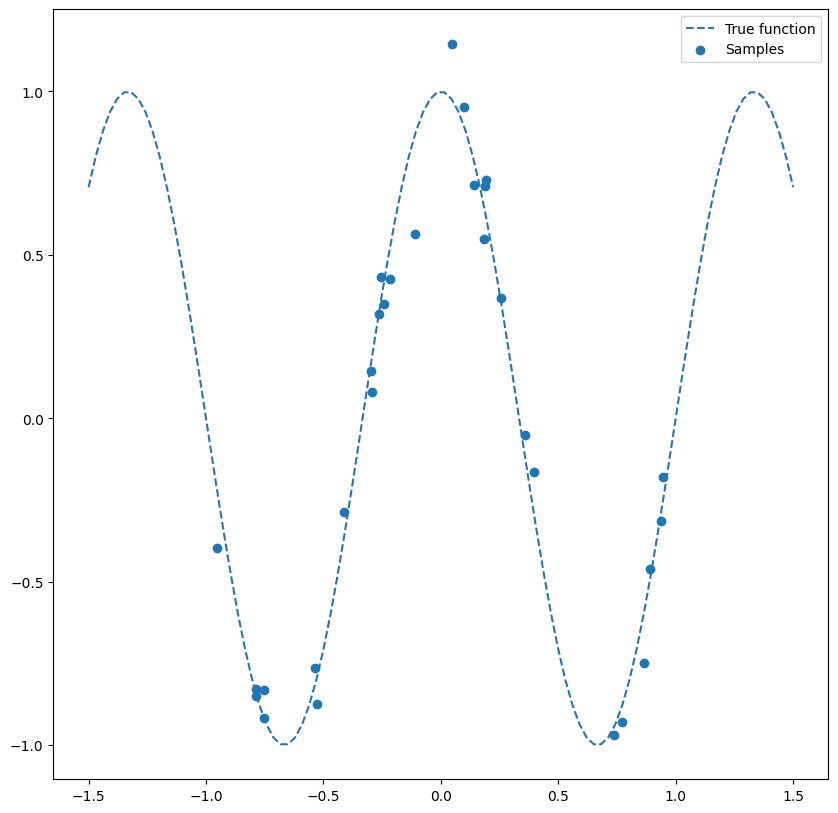

In [2]:
n_samples = 30

# True Function we want to estimate
def true_func(X): return np.cos(1.5 * np.pi * X)

# Noisy Samples from the true function
X = np.sort(2*np.random.rand(n_samples)-1)
y = true_func(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(10,10))
# Plot the true function:
X_plot = np.linspace(-1.5, 1.5, 100)
plt.plot(X_plot, true_func(X_plot), '--',label="True function")
# Plot the data samples
plt.scatter(X,y, label="Samples")
plt.legend(loc="best")
plt.show()

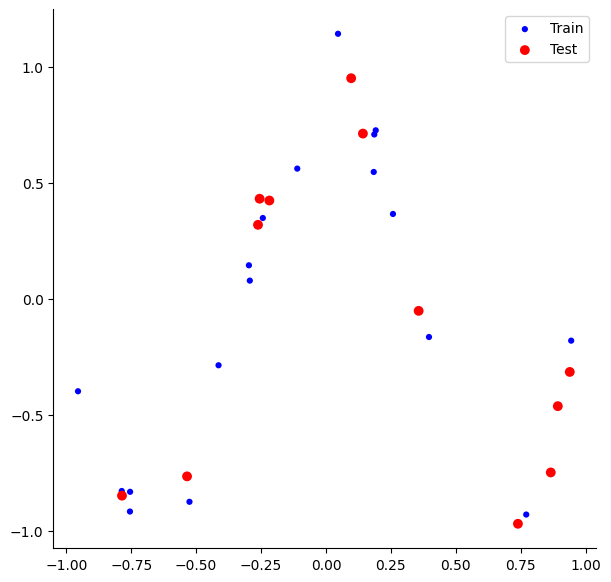

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.4, random_state=0)
plt.figure(figsize=(7,7))
# Plot the data samples
plt.scatter(X_train,y_train, label="Train", c='Blue', s=20, edgecolors='none')
plt.scatter(X_test,y_test, label="Test", c='Red', s=50, edgecolors='none')
#plt.plot(X_plot, true_func(X_plot), 'g--',label="True function")
plt.legend(loc="best")
sns.despine()
plt.show()

In [4]:
# Convert the data into a shape and data-type that PyTorch likes
X_train = X_train.reshape(-1,1).astype(np.float32)
y_train = y_train.reshape(-1,1).astype(np.float32)

### Linear Regression

In [ ]:
#| code-fold: false
input_size  = 1
output_size = 1
# Linear regression model
model = nn.Linear(input_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
learning_rate = 0.1 # alpha
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
#| code-fold: false
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(X_train)
    targets = torch.from_numpy(y_train)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [20/100], Loss: 0.3992
Epoch [40/100], Loss: 0.3596
Epoch [60/100], Loss: 0.3553
Epoch [80/100], Loss: 0.3548
Epoch [100/100], Loss: 0.3548


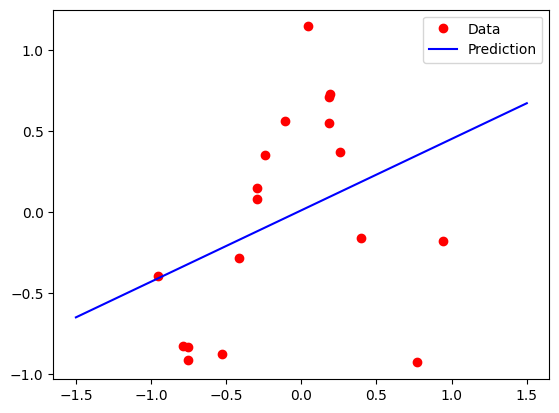

In [7]:
# Plot the graph
plt.figure()
plt.plot(X_train, y_train, 'ro', label='Data')
#predicted = model(torch.from_numpy(X_train)).detach().numpy()
#plt.plot(X_train, predicted, 'b+',label='Predictions')
predicted = model(torch.from_numpy(X_plot.reshape(-1,1).astype(np.float32))).detach().numpy()
plt.plot(X_plot, predicted, 'b', label='Prediction')
plt.legend()
plt.show()

### Neural Network Examples

#### Example of Defining a Network via the full Module class

In [ ]:
#| code-fold: false
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()  
        # Fully-Connected Layer: 1 (input data) -> 5 (hidden node)
        self.fc1 = nn.Linear(input_size, hidden_size)  
        
        # Non-Linear Layer
        self.sigmoid = nn.Sigmoid()
        # You can try other kinds as well
        # self.relu = nn.ReLU()
        # self.elu = nn.ELU()
        
        
        # Fully-Connected Layer: 5 (hidden node) -> 1 (output)
        self.fc2 = nn.Linear(hidden_size, 1) 
    
    # Forward pass builds the model prediction from the inputs
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out
    
# Build the network -- is it not trained yet
model = Net(input_size=1, hidden_size=5)

#### Example of building a model using the `Sequential` helper function

In [9]:
input_size=1
hidden_size=4
model = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.Sigmoid(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, 1)
        )

#### Example using Python list expansions to help build deeper networks

In [10]:
input_size=1
hidden_size=7
num_hidden_layers = 3
activation = nn.ReLU

input_layer = [nn.Linear(input_size, hidden_size),
                activation()]
hidden_layers = num_hidden_layers*[nn.Linear(hidden_size, hidden_size), 
                                   activation()]
output_layer = [ nn.Linear(hidden_size, 1) ] 

# Stack them all together
layers = input_layer + hidden_layers + output_layer

print(layers)

# Use the * operator to "expand" or "unpack" the list
model = nn.Sequential(*layers)

[Linear(in_features=1, out_features=7, bias=True), ReLU(), Linear(in_features=7, out_features=7, bias=True), ReLU(), Linear(in_features=7, out_features=7, bias=True), ReLU(), Linear(in_features=7, out_features=7, bias=True), ReLU(), Linear(in_features=7, out_features=1, bias=True)]


### Now let's do the actual training

In [ ]:
#| code-fold: false
# What Loss function should we use? MSE!
criterion = nn.MSELoss()

# What Optimization procedure should we use?

##### Change these and let's see how it affects the model fit #################
learning_rate = 0.05
weight_decay = 0.0
##########################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

In [ ]:
#| code-fold: false
### Train the model

# Convert numpy arrays to torch tensors
inputs = torch.from_numpy(X_train)
targets = torch.from_numpy(y_train)

num_epochs = 5000
for epoch in range(num_epochs):

    ## Do Forward pass
    # Make predictions
    outputs = model(inputs)
    # Compute the loss function
    loss = criterion(outputs, targets)
    
    ## Update the model
    # Reset the optimizer gradients
    optimizer.zero_grad()
    # Compute the gradient of the loss function
    loss.backward()
    # Do an optimization step
    optimizer.step()
    
    # Print the loss
    if (epoch+1) % 200 == 0:
        print ('Epoch [{:4}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [ 200/5000], Loss: 0.0064
Epoch [ 400/5000], Loss: 0.0025
Epoch [ 600/5000], Loss: 0.0029
Epoch [ 800/5000], Loss: 0.0023
Epoch [1000/5000], Loss: 0.0023
Epoch [1200/5000], Loss: 0.0023
Epoch [1400/5000], Loss: 0.0023
Epoch [1600/5000], Loss: 0.0023
Epoch [1800/5000], Loss: 0.0022
Epoch [2000/5000], Loss: 0.0023
Epoch [2200/5000], Loss: 0.0022
Epoch [2400/5000], Loss: 0.0033
Epoch [2600/5000], Loss: 0.0023
Epoch [2800/5000], Loss: 0.0209
Epoch [3000/5000], Loss: 0.0218
Epoch [3200/5000], Loss: 0.0023
Epoch [3400/5000], Loss: 0.0022
Epoch [3600/5000], Loss: 0.0020
Epoch [3800/5000], Loss: 0.0070
Epoch [4000/5000], Loss: 0.0020
Epoch [4200/5000], Loss: 0.0019
Epoch [4400/5000], Loss: 0.0023
Epoch [4600/5000], Loss: 0.0019
Epoch [4800/5000], Loss: 0.0030
Epoch [5000/5000], Loss: 0.0118


Now let's plot the prediction:

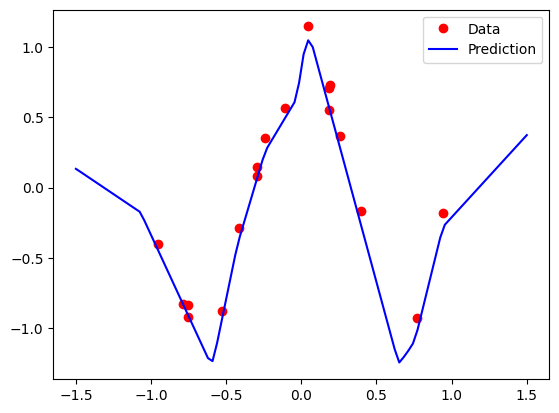

In [13]:
# Plot the graph
plt.figure()
plt.plot(X_train, y_train, 'ro', label='Data')
predicted = model(torch.from_numpy(X_plot.reshape(-1,1).astype(np.float32))).detach().numpy()
plt.plot(X_plot, predicted, 'b', label='Prediction')
plt.legend()
plt.show()

::: {.callout-tip appearance="default"}
### Experiment: Effect of Regularization on Simple Toy Regression Problem
Revisit the above regression code and experiment with the weight decay parameter in the Adam optimizer. How does this affect the learned function? Why do you think this is?:

:::

You can also play around with different activation functions, e.g., `nn.ReLU()`, `nn.Sigmoid()`, `nn.Tanh()`, etc., and the below plot pulls out several options from PyTorch for you to visualize the activation functions:

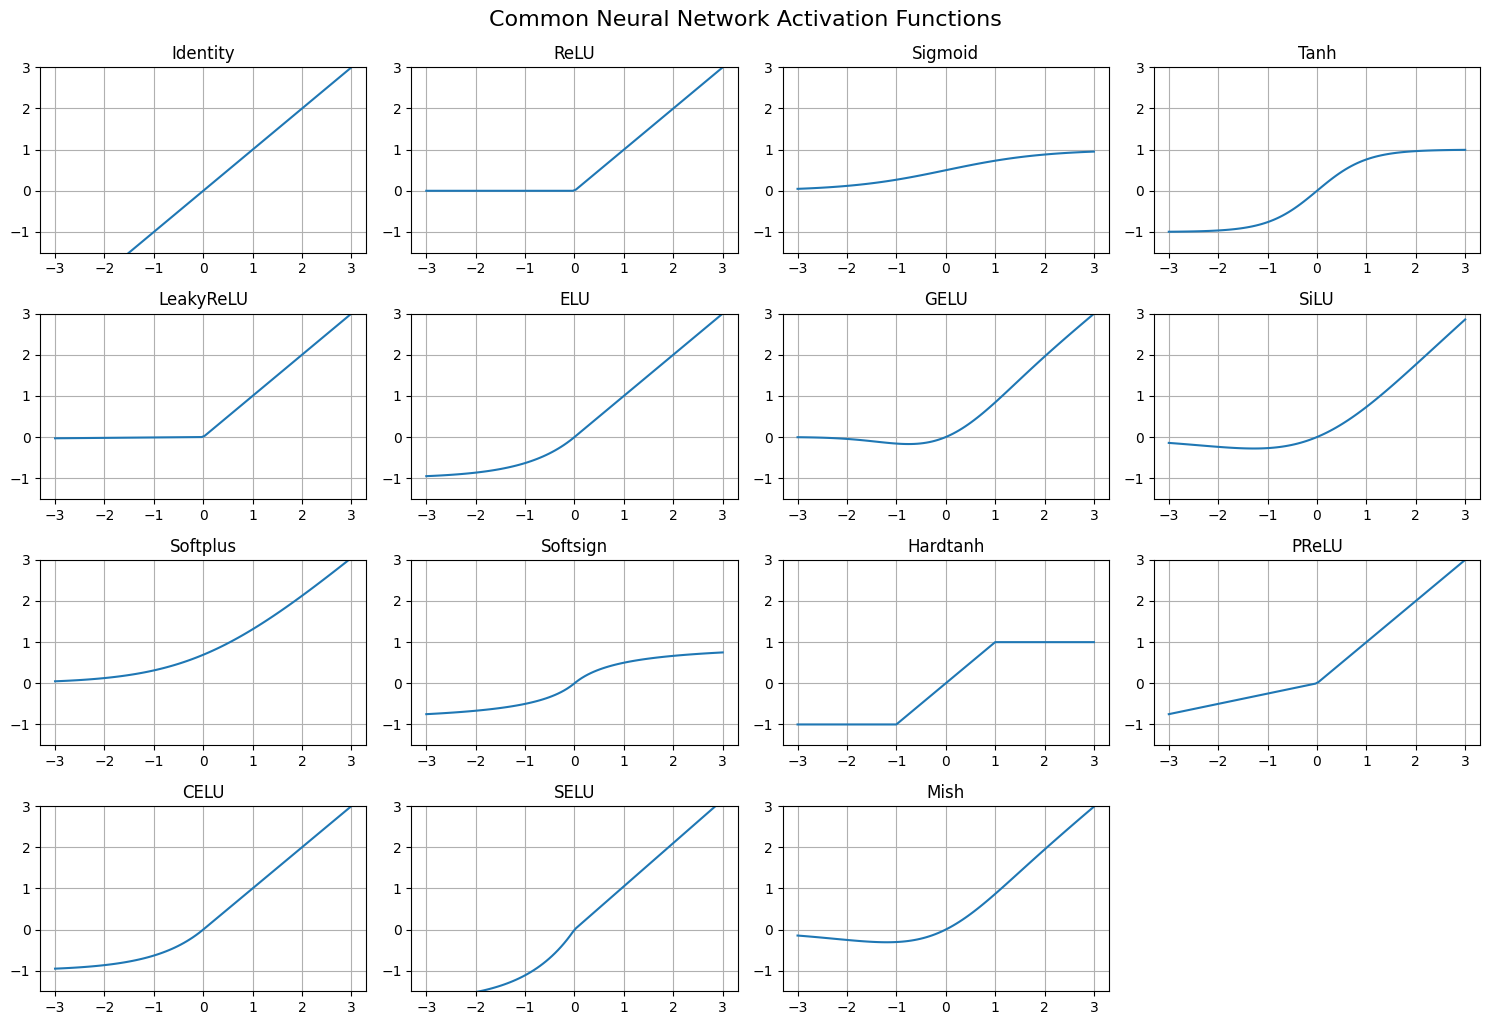

In [14]:
# Common activation functions from PyTorch:
activations = {
    'Identity': nn.Identity(),
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'GELU': nn.GELU(),
    'SiLU': nn.SiLU(),  # also known as Swish
    'Softplus': nn.Softplus(),
    'Softsign': nn.Softsign(),
    'Hardtanh': nn.Hardtanh(),
    'PReLU': nn.PReLU(),
    'CELU': nn.CELU(),
    'SELU': nn.SELU(),
    'Mish': nn.Mish()
}
x = torch.linspace(-3, 3, 100)
n = len(activations)
ncols = 4
nrows = int(np.ceil(n/ncols))
plt.figure(figsize=(15,10))
for i, (name, activation) in enumerate(activations.items()):
    plt.subplot(nrows, ncols, i+1)
    plt.plot(x.numpy(), activation(x).detach().numpy())
    plt.ylim([-1.5, 3])
    plt.title(name)
    plt.grid()
plt.tight_layout()
plt.suptitle("Common Neural Network Activation Functions", y=1.02, fontsize=16)
plt.show()


## Unsupervised Learning using Autoencoders

For this demonstration, we will construct what is fundamentally a 1D function (t) but then embed it in a higher-dimensional space (3D) using a non-linear transformation. This will allow us to compare what a linear method (PCA) can do versus a non-linear method (Autoencoder), on a simple example.

In [15]:
#| code-fold: false
# First we create a simple line (t)
t = np.linspace(-1,1,100)

In [16]:
#| code-fold: false
# Now let's make it 3D and add some (optional) noise
noise_level = 0.01
# You can try out different functions below by uncommenting/commenting them
#X = np.vstack([t,1*t**2,-1*t**3, 0.4*t**5,t**2-t**3,-0.4*t**4]).T
#X = np.vstack([2*np.sin(3*t),1*t**2,-1*t**3, 2*np.sin(6*t+1)-t**3,2*np.cos(3*t)]).T
X = np.vstack([np.sin(2*t),1*t**2,1*np.cos(5*t)]).T + noise_level*np.random.randn(len(t),3)

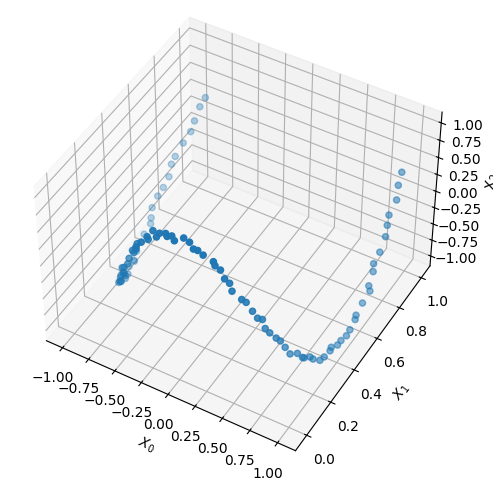

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=45
plt.tight_layout()
plt.show()

We can see that it results in 100 points each of which has three dimensions:

In [18]:
#| code-fold: false
X.shape

(100, 3)

We can attempt to reduce the dimensionality of this data using PCA, but as we can already see from the 3D plot, the data is not linearly embedded in 3D space, so PCA will not be able to find a good low-dimensional representation:

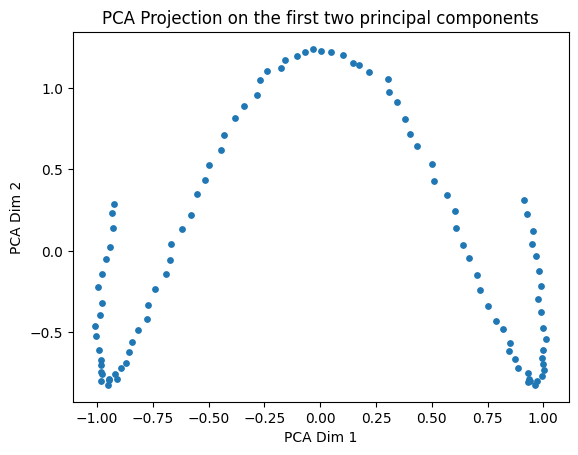

In [19]:
#| code-fold: false
pca = PCA(3)
Z_PCA =pca.fit_transform(X)
plt.figure()
plt.scatter(Z_PCA[:,0],Z_PCA[:,1],s=15)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('PCA Projection on the first two principal components')
plt.show()

And we can also see this reflected in the explained variance, which shows that we need all three original dimensions to explain the variance in the data, even though we know that the data fundamentally lies on a 1D manifold:

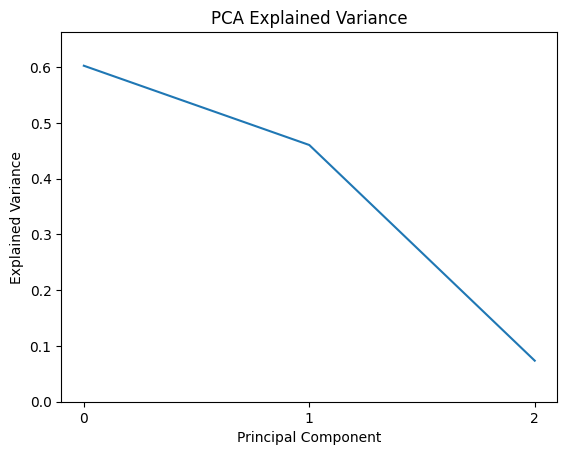

In [20]:
plt.figure()
plt.plot(pca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.xticks([0,1,2])
plt.ylim(0,1.1*max(pca.explained_variance_))
plt.show()

We can see below what happens if we try to truncate PCA to only two dimensions and then reconstruct back to 3D space. The reconstruction is not very good, as expected, and what do you notice about the shape of the reconstructed data?

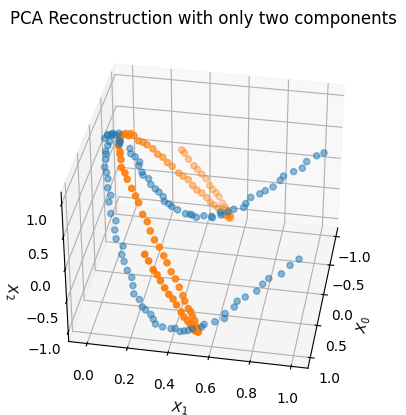

In [21]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pca_2d = PCA(2)
Z_PCA = pca_2d.fit_transform(X)
X_PCA= pca_2d.inverse_transform(Z_PCA)
ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2])

ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=35
ax.azim=10
plt.title("PCA Reconstruction with only two components")
plt.show()

Now let's see how this works using an autoencoder. We will use a very simple architecture with just one hidden layer in the encoder and one hidden layer in the decoder, and we will use 1D latent space (since we know that the data is fundamentally 1D). You will have the option in the below code to change the number of hidden units in the encoder and decoder, as well as the number of latent dimensions, and see how this affects the results.

In [22]:
#| code-fold: false
class Encoder(nn.Module):
    def __init__(self, num_input, num_latent,num_hidden):
        super().__init__()
        self.num_input  = num_input
        self.num_latent = num_latent
        self.num_hidden = num_hidden
        
        # I encourage you to modify the architecture here by adding more layers or changing activation functions, if you wish
        self.encode = nn.Sequential(
            nn.Linear(self.num_input, self.num_hidden),
            nn.ReLU(),
            #nn.Linear(self.num_hidden, self.num_hidden),
            #nn.ReLU(),
            nn.Linear(self.num_hidden, self.num_latent),
        )
        
    def forward(self, X):
        encoded = self.encode(X)
        return encoded
    
class Decoder(nn.Module):
    def __init__(self, num_input, num_latent,num_hidden):
        super().__init__()
        self.num_input  = num_input
        self.num_latent = num_latent
        self.num_hidden = num_hidden
        
        self.decode = nn.Sequential(
            nn.Linear(self.num_latent, self.num_hidden),
            nn.ReLU(),
            #nn.Linear(self.num_hidden, self.num_hidden),
            #nn.ReLU(),
            nn.Linear(self.num_hidden, self.num_input)
        )
        
    def forward(self, Z):
        decoded = self.decode(Z)
        return decoded
    
class AutoEncoder(nn.Module):
    def __init__(self, num_input,num_latent,num_hidden):
        super().__init__()
        self.num_input  = num_input
        self.num_latent = num_latent
        self.num_hidden = num_hidden
        
        self.encoder = Encoder(num_input  = self.num_input,
                               num_latent = self.num_latent,
                               num_hidden = self.num_hidden)
        self.decoder = Decoder(num_input  = self.num_input,
                               num_latent = self.num_latent,
                               num_hidden = self.num_hidden)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded, encoded  # <- return a tuple of two values
    
    def transform(self,X):
        '''Take X and encode to latent space'''
        return self.encoder(X)
    
    def inverse_transform(self,Z):
        '''Take Z and decode to X space'''
        return self.decoder(Z)

In [23]:
#| code-fold: false
# Here we can set some parameters for the autoencoder that we are about to train
# What happens if you change them?
# e.g., increase/decrease num_latent, num_hidden, learning rate, weight decay
num_points, D_orig = X.shape
num_latent = 3
num_hidden = 5
model = AutoEncoder(D_orig,num_latent,num_hidden)
# Create the optimizer object:
# Adam optimizer with learning rate and weight decay
# I encourage you to try out different learning rates and weight decays and
# observe their effect on the model
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-3, 
                        weight_decay=1e-2)
# Add a mean-squared error loss
criterion = nn.MSELoss()

In [24]:
#| code-fold: false
X_torch = torch.from_numpy(X)
X_torch = X_torch.float()

# Depending on the model architecture you use, you may need to increase or decrease this to get good training
epochs=10000
for epoch in range(epochs):
    loss = 0

    optimizer.zero_grad()

    # compute reconstructions
    decoded, encoded = model(X_torch)

    # compute training reconstruction loss
    train_loss = criterion(decoded, X_torch)
            
    # Total Loss
    loss = train_loss 
    
    # compute accumulated gradients
    loss.backward()

    # perform parameter update based on current gradients
    optimizer.step()

    # display the epoch training loss
    if epoch%500==0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss.item()))

epoch : 1/10000, loss = 0.716544
epoch : 501/10000, loss = 0.350305
epoch : 1001/10000, loss = 0.090813
epoch : 1501/10000, loss = 0.010054
epoch : 2001/10000, loss = 0.000795
epoch : 2501/10000, loss = 0.000162
epoch : 3001/10000, loss = 0.000120
epoch : 3501/10000, loss = 0.000097
epoch : 4001/10000, loss = 0.000081
epoch : 4501/10000, loss = 0.000073
epoch : 5001/10000, loss = 0.000062
epoch : 5501/10000, loss = 0.000054
epoch : 6001/10000, loss = 0.000035
epoch : 6501/10000, loss = 0.000016
epoch : 7001/10000, loss = 0.000006
epoch : 7501/10000, loss = 0.000000
epoch : 8001/10000, loss = 0.000000
epoch : 8501/10000, loss = 0.000000
epoch : 9001/10000, loss = 0.000000
epoch : 9501/10000, loss = 0.000000


Now that the model is trained, we can put the data through the encoder and decoder to pull out both the encoded (i.e., latent) representation of each point, as well as the decoded (i.e., reconstructed) version of each point, and visualize the results.

In [25]:
#|code-fold: false
decoded, encoded = model(X_torch)

First, let's take a look at the reconstructed data in the original 3D space, compared to the original data:

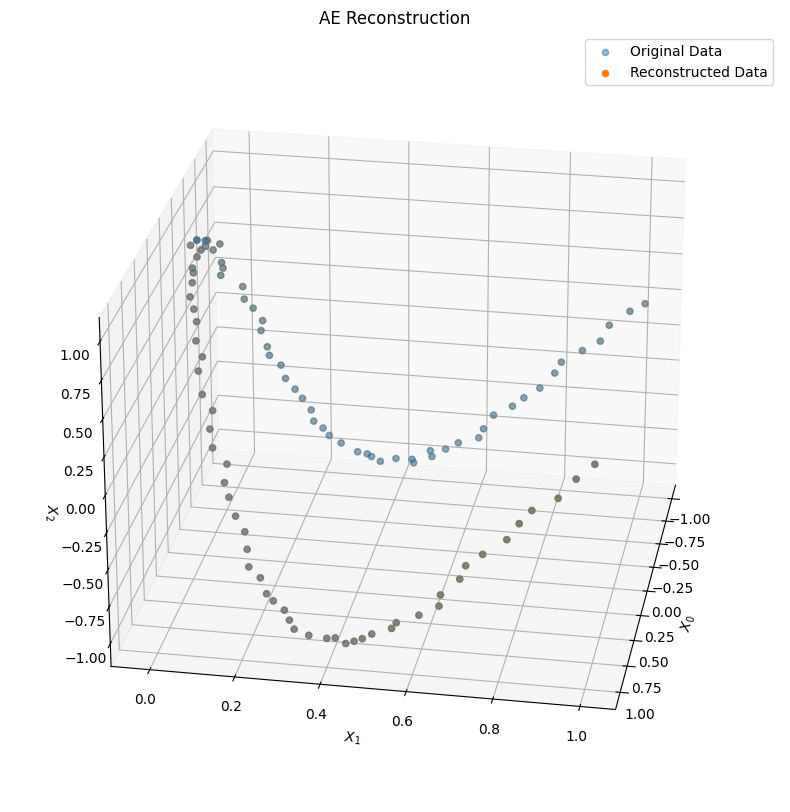

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
X_P = decoded.detach().numpy()

ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_P[:,0], X_P[:,1], X_P[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=25
ax.azim=10
plt.legend(['Original Data','Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

Let's see how the encoded (i.e., latent) points actually look in Z space:

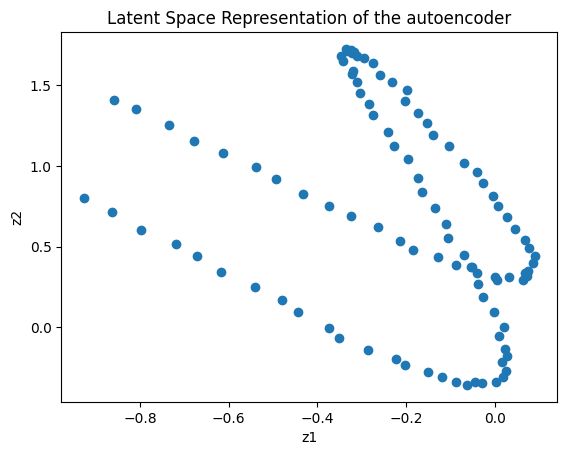

In [ ]:
Z = encoded.cpu().detach().numpy()
# Only works if num_latent >=2
if num_latent>=2:
    plt.figure()
    plt.scatter(Z[:,0],Z[:,1])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Representation of the autoencoder')
    plt.show()

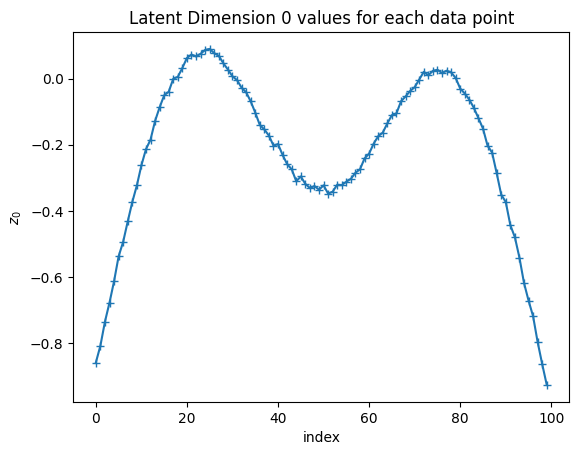

In [29]:
plt.figure()
plt.plot(Z[:,0],marker='+')
plt.xlabel('index')
plt.ylabel('$z_0$')
plt.title('Latent Dimension 0 values for each data point')
plt.show()

We can also look at a pairplot of the points in the latent space to get a sense of how the different dimensions correlate with each other:

<Figure size 640x480 with 0 Axes>

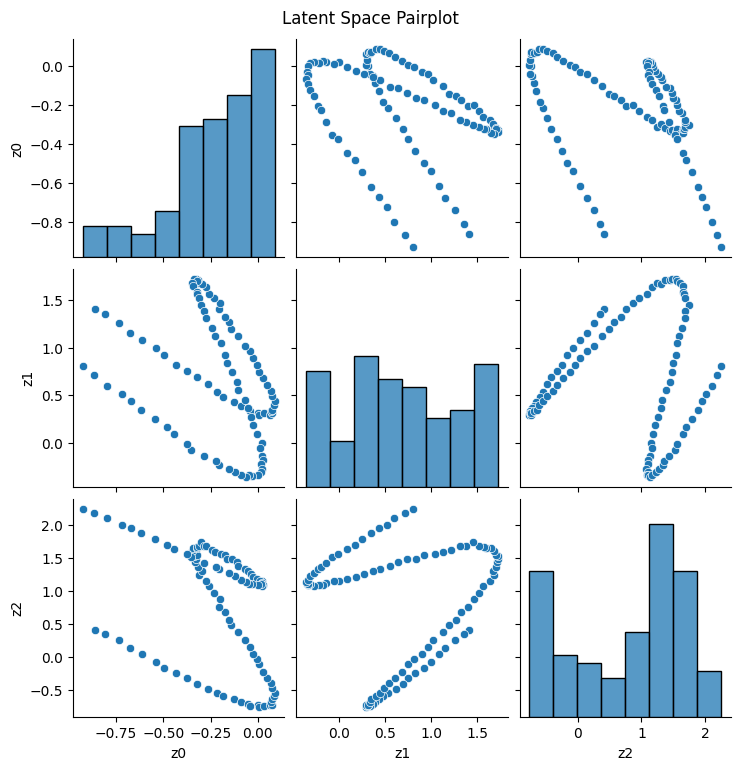

In [30]:
df = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
plt.figure()
sns.pairplot(df)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

::: {.callout-tip appearance="default"}
### Experiment: Effect on Autoencoder Architecture on Reconstruction Accuracy and Latent Space Behavior 
Revisit the above autoencoder code and experiment by changing the number of hidden units, the bottleneck (latent) dimension, and the number of layers in the encoder and decoder. How do these changes affect the reconstruction accuracy and the behavior of the learned latent space? Consider some of the below questions:

- We know that the data is fundamentally 1D, but why does setting the autoencoder latent dimension to 1 not work well? Why might it be useful to have a latent dimension larger than the true dimensionality of the data for this type of model?
- What happens if you set the latent dimension to be three or larger? Why do you think this happens? What have we given up by doing this?
- As you increase or decrease the number of hidden units in Autoencoder, how does this affect the reconstruction accuracy? Why do you think this is? Consider in particular the case where the number of hidden units is one or two.
- Unlike in PCA, when we re-run the autoencoder training, we get different results each time. Why do you think this is?
- Unlike PCA, the autoencoder does not guarantee that the latent dimensions are orthogonal or ordered by importance (e.g., $z_0$ being more important than $z_1$, etc.). Do you see any evidence of this in the learned latent space? Why do you think this is?
- The Autoencoder used a ReLU activation function in the hidden layers. How does this manifest in the way that the network reconstructs the data? (Note, this may only be visible if you set the latent dimension to 1 and the number of hidden units to a small number, e.g., 2 or 3).
- We can see that when we set the latent dimension to two or greater, the autoencoder can reconstruct the data well, but it is not capturing the intrinsic dimensionality of the data. One way we might do this is by adding L1 regularization to the latent space coordinates, which is commented out in the code above. Try adding in this regularization. Does it fix the problem?

:::

## Least Volume Regularization

One of the problems that we saw in Autoencoders is that the latent space does not have any particular structure, and in particular, it is not guaranteed to be ordered, in the same sense as PCA. It was also difficult for us to determine the exact "size" of the latent dimension, since, as we saw, setting the latent dimension to 1 did not work well, even though we knew that the data was fundamentally 1D, due to training variability and the fact that the autoencoder could get trapped in local minima. One possible solution to this is to add a regularization term that encourages the latent space to be small in some sense. One such regularization is called [Least Volume Regularization](https://arxiv.org/abs/2404.17773), which encourages the latent space to have a small volume by penalizing the volume of the encoded points in the latent space.

In [31]:
class _Combo(nn.Module):
    def forward(self, input):
        return self.model(input)

class LinearCombo(_Combo):
    def __init__(self, in_features, out_features, activation=nn.LeakyReLU(0.2)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, out_features),
            activation
        )

class MLP(nn.Module):
    """Regular fully connected network generating features.

    Args:
        in_features: The number of input features.
        out_feature: The number of output features.
        layer_width: The widths of the hidden layers.
        combo: The layer combination to be stacked up.

    Shape:
        - Input: `(N, H_in)` where H_in = in_features.
        - Output: `(N, H_out)` where H_out = out_features.
    """
    def __init__(
        self, in_features: int, out_features:int, layer_width: list,
        combo = LinearCombo
        ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.layer_width = list(layer_width)
        self.model = self._build_model(combo)

    def forward(self, input):
        return self.model(input)

    def _build_model(self, combo):
        model = nn.Sequential()
        idx = -1
        for idx, (in_ftr, out_ftr) in enumerate(self.layer_sizes[:-1]):
            model.add_module(str(idx), combo(in_ftr, out_ftr))
        model.add_module(str(idx+1), nn.Linear(*self.layer_sizes[-1])) # type:ignore
        return model

    @property
    def layer_sizes(self):
        return list(zip([self.in_features] + self.layer_width,
        self.layer_width + [self.out_features]))

In [ ]:
#| code-fold: false
ambient_dim = X.shape[1]

# Change the below latent dimension to see what happens to the embedded points
latent_dim = 3

width = ambient_dim * 16
encoder = MLP(ambient_dim, latent_dim, [width] * 4)
decoder = MLP(latent_dim, ambient_dim, [width] * 4)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

In [ ]:
#| code-fold: false
# Set X to a torch tensor:
X_torch = torch.from_numpy(X).float()

for i in range(5000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    loss = rec_loss
    # If you want, you can even add an L1 penalty on the latent space
    # to try to encourage sparsity by uncommenting the line below:
    #loss += 1e-3 * torch.mean(torch.abs(z))

    loss.backward()
    opt.step()
    if (i+1) % 100 == 0:
        print(f'Epoch {i:4}: rec = {rec_loss:.5g}')

Epoch   99: rec = 0.39166
Epoch  199: rec = 0.31308
Epoch  299: rec = 0.048501
Epoch  399: rec = 0.023062
Epoch  499: rec = 0.015194
Epoch  599: rec = 0.010049
Epoch  699: rec = 0.0068286
Epoch  799: rec = 0.0048156
Epoch  899: rec = 0.0035384
Epoch  999: rec = 0.0026096
Epoch 1099: rec = 0.0018915
Epoch 1199: rec = 0.001313
Epoch 1299: rec = 0.00084967
Epoch 1399: rec = 0.00053819
Epoch 1499: rec = 0.00027124
Epoch 1599: rec = 0.00014737
Epoch 1699: rec = 0.00010135
Epoch 1799: rec = 8.2536e-05
Epoch 1899: rec = 7.4167e-05
Epoch 1999: rec = 6.9067e-05
Epoch 2099: rec = 6.5697e-05
Epoch 2199: rec = 6.2941e-05
Epoch 2299: rec = 6.0584e-05
Epoch 2399: rec = 5.8694e-05
Epoch 2499: rec = 5.6992e-05
Epoch 2599: rec = 5.5272e-05
Epoch 2699: rec = 5.3765e-05
Epoch 2799: rec = 5.2397e-05
Epoch 2899: rec = 5.1138e-05
Epoch 2999: rec = 5.0006e-05
Epoch 3099: rec = 4.8935e-05
Epoch 3199: rec = 4.7868e-05
Epoch 3299: rec = 4.6667e-05
Epoch 3399: rec = 4.5643e-05
Epoch 3499: rec = 4.4691e-05
Epoch 

Now that the autoencoder has been trained, let's take a look at the standard deviation of the embedded points (i.e., in $z$). We can sort the latent dimensions according to which dimensions have the highest standard deviation in Z.

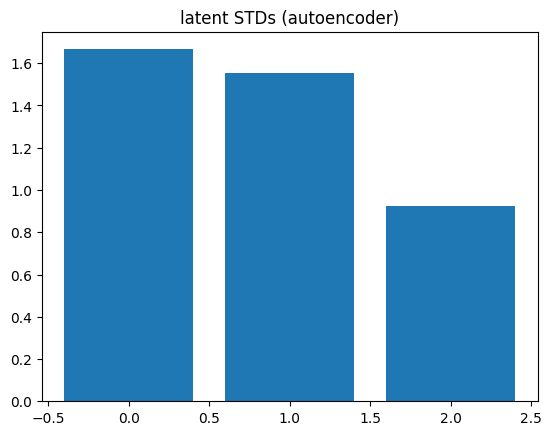

In [34]:
encoder.eval()
decoder.eval()

# Embed the data into Z using the trained encoder
with torch.no_grad():
    z = encoder(X_torch)
# Now let's sort the latent codes by which ones have the
# largest standard deviation in Z:
idx = z.std(0).argsort(descending=True)

plt.figure()
plt.bar(np.arange(z.std(0).size(-1)), z.std(0)[idx])
plt.title('latent STDs (autoencoder)')
plt.show()

As with before, we can plot some of the data points in Z space:

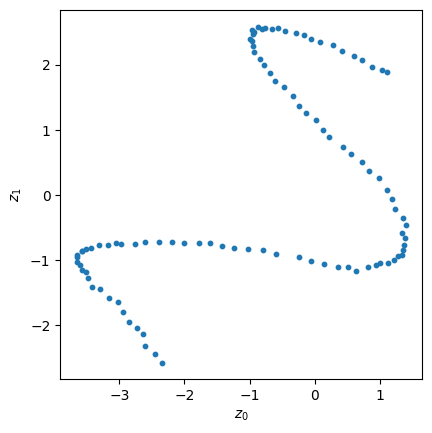

In [35]:
plt.figure()
plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy(), s=10)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

We can also plot the covariance among the latent codes of the embedded data:

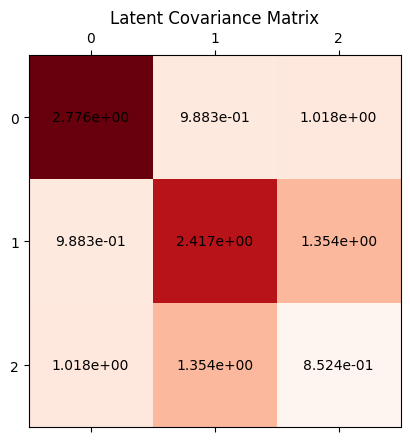

In [ ]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.figure()
plt.matshow(cov, cmap='Reds')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

We can also get a general idea about how well we are reconstructing the original data by comparing the ground truth values versus predicted (i.e., encoded then decoded) data points -- this is often called a parity plot:

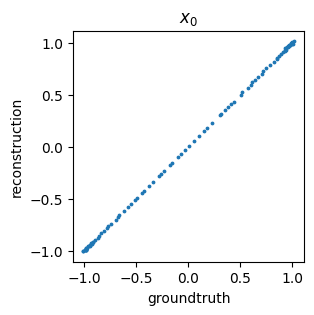

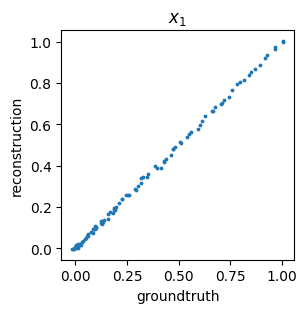

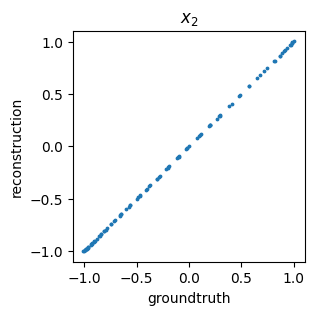

In [37]:
X_ = decoder(z).detach()

for i in range(X_torch.size(-1)):
    plt.figure(figsize=(3,3))
    plt.scatter(X[:, i], X_[:, i], s=3)
    plt.gca().set_aspect('equal')
    plt.xlabel('groundtruth')
    plt.ylabel('reconstruction')
    plt.title('$x_{}$'.format(i))
    plt.show()

Lastly, we can visualize a pairplot of the latent space to see how the different dimensions correlate with each other:

<Figure size 640x480 with 0 Axes>

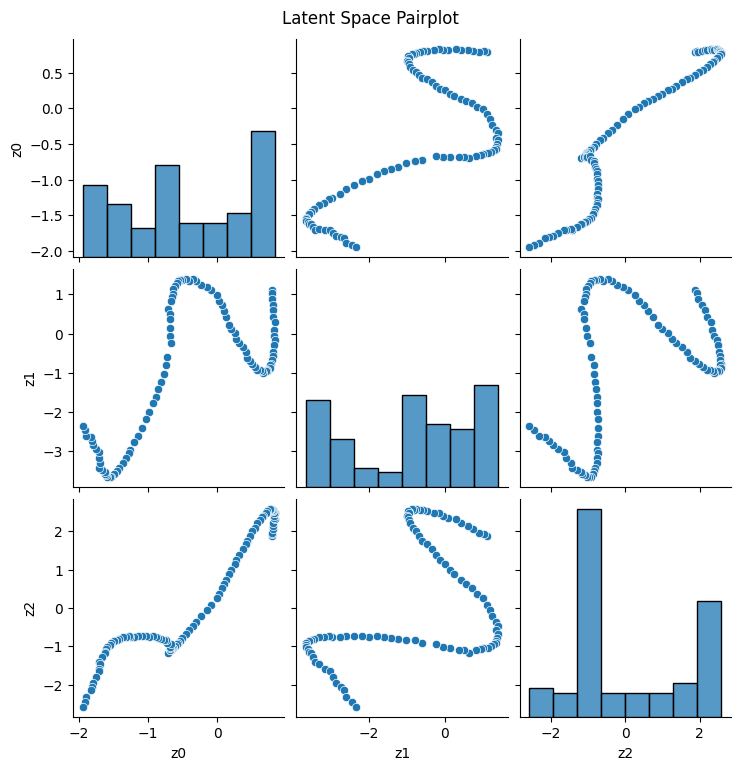

In [38]:
df = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
plt.figure()
sns.pairplot(df)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()


## How might we select the right order in an Autoencoder? Building the case for Least Volume Analysis (LVA)

Our explorations above exposed both the advantages and disadvantages of using non-linear maps to attempt to embed and capture the underlying distribution and topology of the data.

Below we describe the basic principle of "Least Volume" regularization in Autoencoders and demonstrate how it can be useful in providing automated order selection in over-parameterized Autoencoders. It can allow us to capture relevant topological structure, but with minimal dimension.

![](https://arxiv.org/html/2404.17773v1/x1.png)

Image above from: Qiuyi Chen and Mark Fuge, ["Least Volume Analysis"](https://arxiv.org/abs/2404.17773)


In general, the idea behind least volume is that we want to encourage the latent space to take up as little volume as possible, while still being able to reconstruct the data well. This can be achieved by adding a regularization term to the loss function that penalizes the volume of the latent space. A simple way to do this is to penalize the geometric mean of the standard deviation of the latent dimensions, which encourages the latent space to be small in all dimensions. Specifically, we can minimize the product of all elements of the latent code's standard deviation vector $\prod \sigma$, which is equivalent to minimizing the exponential of the mean of the log of the standard deviation vector:

`vol_loss = torch.exp(torch.log(z.std(0) + η).mean())`

We add a small constant `η` to avoid numerical issues when any one of the standard deviation's in any dimension approaches zero -- that is when the autoencoder eliminates a dimension, and thus $\prod \sigma$ would have a zero in the product. This loss term can be added to the reconstruction loss, weighted by a hyperparameter `λ`, to form the total loss.

In principle, while this loss can encourage the latent space to reduce its volume, there is one catch: the autoencoder could simply scale up the weights in the encoder and decoder to make the latent space arbitrarily small, while still being able to reconstruct the data well. To prevent this, we have to prevent the decoder from being able to arbitrarily increase its weights, and one easy way to enforce this is through *spectral normalization* on the weights of the decoder, which constrains the Lipschitz constant of the decoder to be at most 1. By preventing the decoder from scaling up its weights too much, and the encoder cannot easily defeat the volume penalty by isotropically shrinking the weights, and thus the only way to achieve a good volume penalty is to actually reduce dimensions.

Fun Fact: It turns out that in the case of an Autoencoder that only uses Linear layers, and with no activation functions, the least volume penalty is equivalent to PCA. That is, PCA can be seen as a special case of Least Volume Autoencoder. For more details on the mathematical proof, see [Proposition 15](https://arxiv.org/html/2404.17773v2#Thmtheorem15) in the original paper.


Below code implements the spectral normalized decoder:

In [ ]:
#| code-fold: false
from torch.nn.utils.parametrizations import spectral_norm

class SNLinearCombo(_Combo):
    def __init__(self, in_features, out_features, activation=nn.LeakyReLU(0.2)):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(in_features, out_features)),
            activation
        )

class SNMLP(MLP):
    def __init__(
        self, in_features: int, out_features: int, layer_width: list,
        combo=SNLinearCombo):
        super().__init__(in_features, out_features, layer_width, combo)

    def _build_model(self, combo):
        model = nn.Sequential()
        idx = -1
        for idx, (in_ftr, out_ftr) in enumerate(self.layer_sizes[:-1]):
            model.add_module(str(idx), combo(in_ftr, out_ftr))
        # Note here is the main difference: the last layer also has spectral normalization
        # This was not the case in the previous MLP definition
        model.add_module(str(idx+1), spectral_norm(nn.Linear(*self.layer_sizes[-1])))
        return model

In [ ]:
#| code-fold: false
width = ambient_dim * 16
# Note in particular the lack of the bottleneck choice below
# That is, we don't need to actually pick a bottleneck dimension -- LVA automatically determines this, like PCA
encoder = MLP(ambient_dim, ambient_dim, [width] * 4)
# Note also the change in the decoder to have spectral normalization
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [ ]:
#| code-fold: false
η, λ = 0.01, 0.01

for i in range(20000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    # Note below the least volume loss
    vol_loss = torch.exp(torch.log(z.std(0) + η).mean())
    loss = rec_loss + λ * vol_loss
    loss.backward()
    opt.step()


    if (i+1) % 1000 == 0:
        # Print floats with 5 significant digits and fill epoch with leading spaces if under 4 digits
        print(f'Epoch {i:4}: rec = {rec_loss:.5g}, vol = {vol_loss:.5g}')

Epoch  999: rec = 0.015768, vol = 0.20888
Epoch 1999: rec = 0.0093937, vol = 0.2092
Epoch 2999: rec = 0.0075273, vol = 0.21866
Epoch 3999: rec = 0.0061228, vol = 0.26539
Epoch 4999: rec = 0.0049839, vol = 0.23421
Epoch 5999: rec = 0.0042767, vol = 0.1931
Epoch 6999: rec = 0.0035521, vol = 0.17556
Epoch 7999: rec = 0.0034988, vol = 0.22726
Epoch 8999: rec = 0.0025694, vol = 0.1861
Epoch 9999: rec = 0.0028511, vol = 0.202
Epoch 10999: rec = 0.0022147, vol = 0.17631
Epoch 11999: rec = 0.0021955, vol = 0.17034
Epoch 12999: rec = 0.0020662, vol = 0.19222
Epoch 13999: rec = 0.0019016, vol = 0.20411
Epoch 14999: rec = 0.0015431, vol = 0.15869
Epoch 15999: rec = 0.0014341, vol = 0.18272
Epoch 16999: rec = 0.0015622, vol = 0.18977
Epoch 17999: rec = 0.0013786, vol = 0.17417
Epoch 18999: rec = 0.0017483, vol = 0.15937
Epoch 19999: rec = 0.0014537, vol = 0.20069


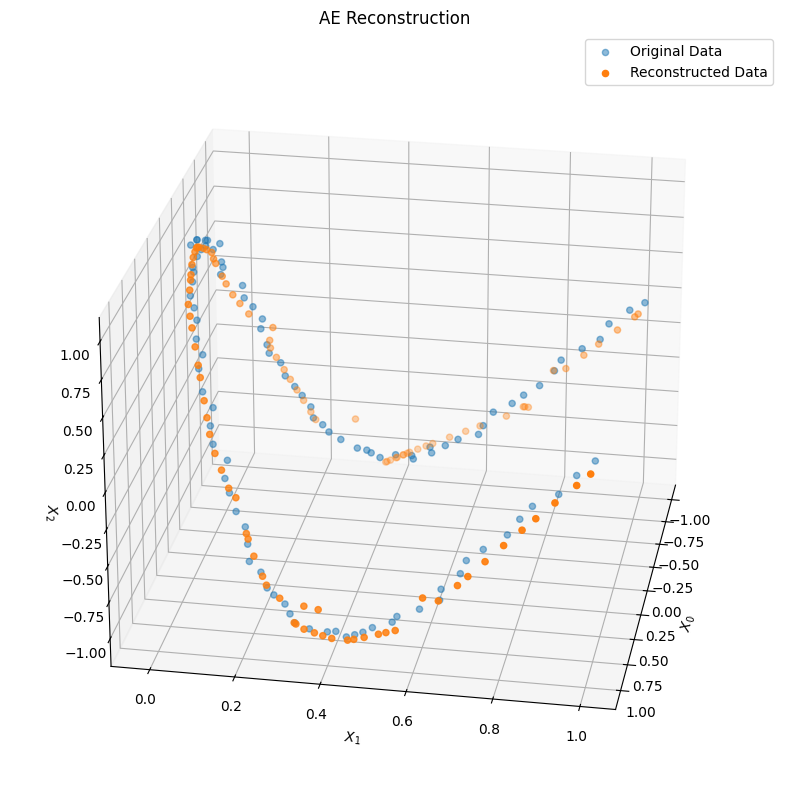

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
X_P = decoder(encoder(X_torch)).detach().numpy()
#X_P = decoded.detach().numpy()

ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_P[:,0], X_P[:,1], X_P[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=25
ax.azim=10
plt.legend(['Original Data','Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

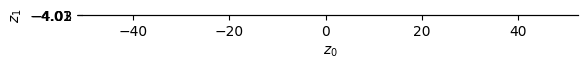

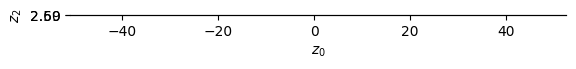

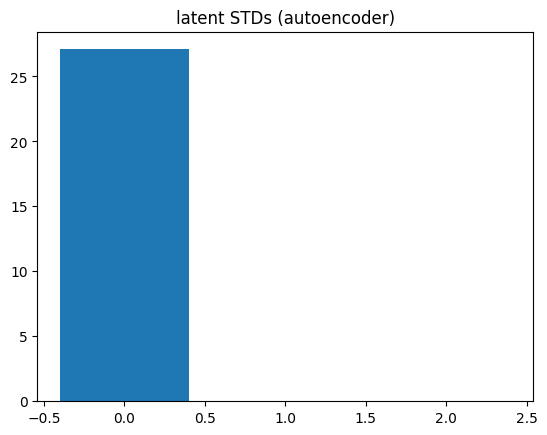

In [43]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    z = encoder(X_torch)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy(), s=10)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[2]].cpu().detach().numpy(),s=10)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_2$')
plt.show()

# Plot the latent STDs by magnitude in the sorted order:
plt.figure()
plt.bar(np.arange(z.std(0).size(-1)), z.std(0)[idx])
plt.title('latent STDs (autoencoder)')
plt.show()


Plotting the latent code covariances:

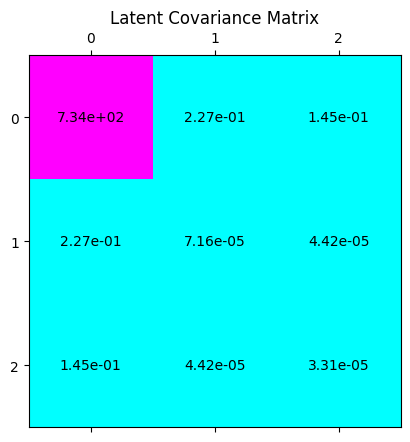

In [44]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

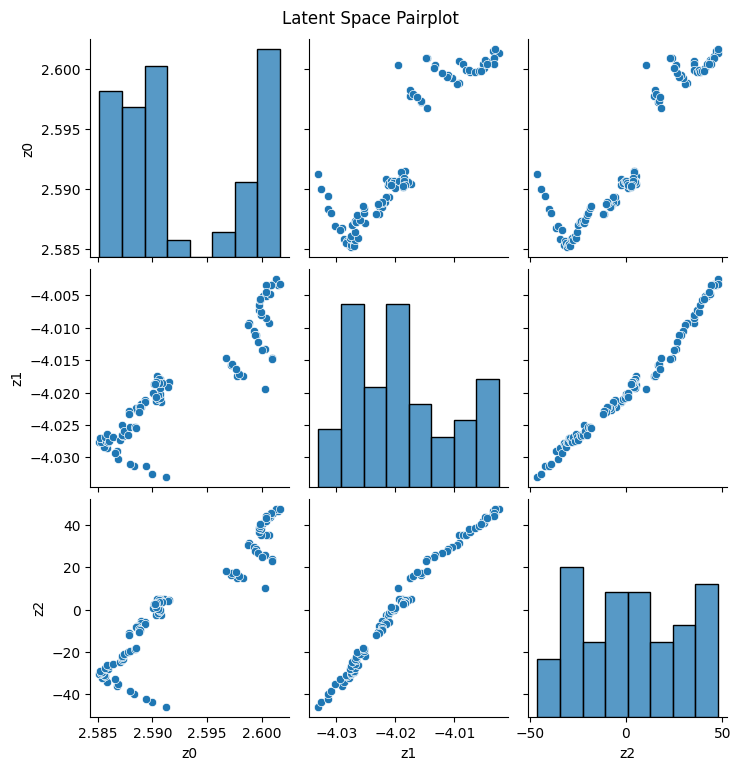

In [45]:
df = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
plt.figure()
sns.pairplot(df)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

Let's check again the reconstruction errors:

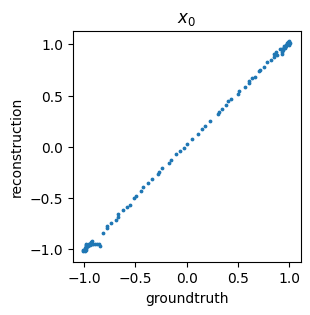

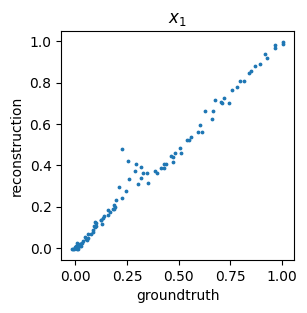

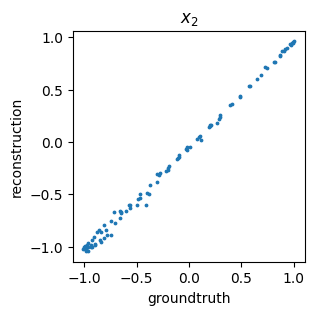

In [46]:
X_ = decoder(z).detach()

for i in range(X_torch.size(-1)):
    plt.figure(figsize=(3,3))
    plt.scatter(X[:, i], X_[:, i], s=3)
    plt.gca().set_aspect('equal')
    plt.xlabel('groundtruth')
    plt.ylabel('reconstruction')
    plt.title('$x_{}$'.format(i))
    plt.show()